# Churn Analysis

Customer churn refers to when a customer (player, subscriber, user, etc.) ceases his or her relationship with a company.

In the dataset each row represents a subscribing telephone customer and each column contains customer attributes such as phone number, call minutes used during different times of day, charges incurred for services, lifetime account duration, and whether or not the customer is still a customer.

In [64]:
%matplotlib inline

In [65]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [66]:
churn_df = pd.read_csv('churn.csv')

In [67]:
col_names = churn_df.columns.tolist()

In [68]:
col_names

['State',
 'Account Length',
 'Area Code',
 'Phone',
 "Int'l Plan",
 'VMail Plan',
 'VMail Message',
 'Day Mins',
 'Day Calls',
 'Day Charge',
 'Eve Mins',
 'Eve Calls',
 'Eve Charge',
 'Night Mins',
 'Night Calls',
 'Night Charge',
 'Intl Mins',
 'Intl Calls',
 'Intl Charge',
 'CustServ Calls',
 'Churn?']

In [69]:
to_show = col_names[:6] + col_names[-6:]
churn_df[to_show].head(6)

,State,Account Length,Area Code,Phone,Int'l Plan,VMail Plan,Night Charge,Intl Mins,Intl Calls,Intl Charge,CustServ Calls,Churn?
0,OH,107.0,415.0,371-7191,no,yes,11.45,13.7,3.0,3.70,1.0,False.
1,NJ,137.0,415.0,358-1921,no,no,7.32,12.2,5.0,3.29,0.0,False.
2,OH,84.0,408.0,375-9999,yes,no,8.86,6.6,7.0,1.78,2.0,False.
3,OK,75.0,415.0,330-6626,yes,no,8.41,10.1,3.0,2.73,3.0,False.
4,AL,118.0,510.0,391-8027,yes,no,9.18,6.3,6.0,1.70,0.0,False.
5,MA,121.0,510.0,355-9993,no,yes,9.57,7.5,7.0,2.03,3.0,False.


## pre-processing

Convert columns to numerical

In [70]:
# We don't need these columns
to_drop = ['State', 'Area Code', 'Phone', 'Churn?']
churn_feat_space = churn_df.drop(to_drop, axis=1)

# 'yes'/'no' has to be converted to boolean values
# NumPy converts these from boolean to 1. and 0. later
yes_no_cols = ["Int'l Plan", "VMail Plan"]
churn_feat_space[yes_no_cols] = churn_feat_space[yes_no_cols] == 'yes'
churn_feat_space.interpolate(inplace=True)

# Pull out features for future use
features = churn_feat_space.columns

X = churn_feat_space.values.astype(np.float)

# Target data
churn_result = churn_df['Churn?']
y = np.where(churn_result == 'True.',1,0)

# This is important
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X = scaler.fit_transform(X)

print("Feature space holds %d observations and %d features" % X.shape)
print("Unique target labels:", np.unique(y))

Feature space holds 3332 observations and 17 features
Unique target labels: [0 1]


## Model training

We will train mutliple model and to do that write a helper function that first splits the dataset into train and test using KFold cross-validation and then trains a ML model.

Then we execute that funcion for 3 types of models:
1. Support Vector Machine classifier
2. Random Forest classifier
3. K Nearist Neighbors classifier

In [71]:
from sklearn.model_selection import KFold
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier as RF
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.linear_model import LogisticRegression as LR
from sklearn.ensemble import GradientBoostingClassifier as GBC
from sklearn.metrics import recall_score

In [72]:
def run_cv(X, y, clf_class, **kwargs):
    y_pred = y.copy()
    kf = KFold(n_splits=5, shuffle=True)
    
    # Iterate through folds
    for train_index, test_index in kf.split(X, y):
        X_train, X_test = X[train_index], X[test_index]
        y_train = y[train_index]
        
        # Initialize a classifier with key word arguments
        clf = clf_class(**kwargs)
        clf.fit(X_train,y_train)
        y_pred[test_index] = clf.predict(X_test)
    return y_pred, clf

In [73]:
svc, SVC = run_cv(X, y, SVC)
rf, RF = run_cv(X, y, RF)
knn, KNN = run_cv(X, y, KNN)
lr, LR = run_cv(X, y, LR)
gbc, GBC = run_cv(X, y, GBC)

## Model scoring

We can start doing a simple analysis of the accuracy of the 5 models

In [74]:
def accuracy(y_true, y_pred):
    # NumPy interprets True and False as 1. and 0.
    return np.mean(y_true == y_pred)

In [75]:
print("Support vector machines:", "%.3f" % accuracy(y, svc))
print("Random forest:", "%.3f" % accuracy(y, rf))
print("K-nearest-neighbors:", "%.3f" % accuracy(y, knn))
print("Logistic Regression:", "%.3f" % accuracy(y, lr))
print("Gradient Boosting Classifier:", "%.3f" % accuracy(y, gbc))

Support vector machines: 0.913
Random forest: 0.937
K-nearest-neighbors: 0.887
Logistic Regression: 0.865
Gradient Boosting Classifier: 0.946


Accuracy gives us an idea of the performance of the model but its not a good idea to use only one metric. For this type of analysis its a good idea to plot the confusion matrix of the models.

In [76]:
from sklearn.metrics import confusion_matrix

y = np.array(y)
class_names = np.unique(y)

confusion_matrices = [
    ( "Support Vector Machines", confusion_matrix(y, svc) ),
    ( "Random Forest", confusion_matrix(y, rf) ),
    ( "K-Nearest-Neighbors", confusion_matrix(y, knn) ),
    ( "Logistic Regression", confusion_matrix(y, lr) ),
    ( "Gradient Boosting Classifier", confusion_matrix(y, gbc) )
]

In [77]:
def draw_confusion_matrices(confusion_matricies,class_names):
    class_names = class_names.tolist()
    for cm in confusion_matrices:
        classifier, cm = cm[0], cm[1]
        print(cm)
        
        fig = plt.figure()
        ax = fig.add_subplot(111)
        cax = ax.matshow(cm)
        plt.title('Confusion matrix for %s' % classifier)
        fig.colorbar(cax)
        ax.set_xticklabels([''] + class_names)
        ax.set_yticklabels([''] + class_names)
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.show()

[[2821   38]
 [ 252  221]]


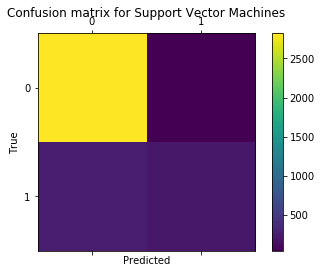

[[2824   35]
 [ 174  299]]


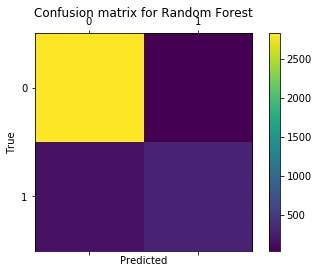

[[2808   51]
 [ 325  148]]


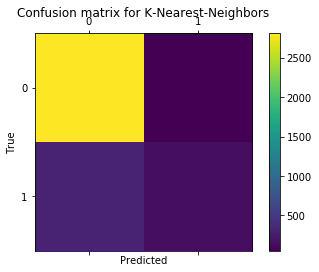

[[2782   77]
 [ 372  101]]


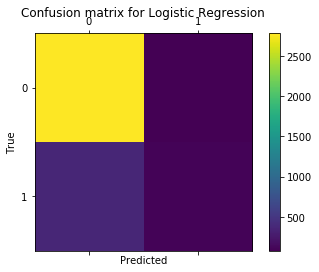

[[2817   42]
 [ 137  336]]


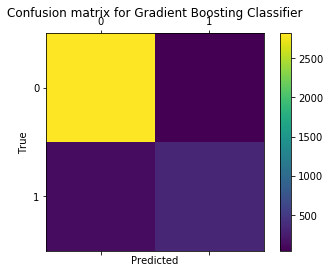

In [78]:
draw_confusion_matrices(confusion_matrices, class_names)

The confusion matrix gives us an idea on what models are preforming better and which ones are giving false-positives adn true-negatives. This is an important question to ask, When an individual churns, how often does my classifier predict that correctly? We can measure this using "recall".

In [79]:
print("Support vector machines:", "%.3f" % recall_score(y, svc))
print("Random forest:", "%.3f" % recall_score(y, rf))
print("K-nearest-neighbors:", "%.3f" % recall_score(y, knn))
print("Linear Regression:", "%.3f" % recall_score(y, lr))
print("Gradient Boosting Classifier:", "%.3f" % recall_score(y, gbc))

Support vector machines: 0.467
Random forest: 0.632
K-nearest-neighbors: 0.313
Linear Regression: 0.214
Gradient Boosting Classifier: 0.710


We can see that around 73% of the time the GBC classified this correctly.

## Prediction

Now we can use the best model (GBC) to make a prediction on whether a customer is going to remain or not.

In [80]:
GBC.predict_proba(X[0:10])

array([[0.96955153, 0.03044847],
       [0.95791478, 0.04208522],
       [0.94367584, 0.05632416],
       [0.9464281 , 0.0535719 ],
       [0.92802393, 0.07197607],
       [0.61294442, 0.38705558],
       [0.96264408, 0.03735592],
       [0.90586685, 0.09413315],
       [0.96672074, 0.03327926],
       [0.20913892, 0.79086108]])